# About this notebook
In this notebook, it was build on top of the baseline model (Resnet-34 with 10% of the entire data). The idea is try to push the target accuracy using less training time. 

Therefore, this model is very similar to the final model except the following changes:

1. Training set is 50% of the entire Food-101 training set with a stratified split based on 101 classes to maintain the same ratio as the entire training set. 
2. Validation set is the test-set of the Food-101 test set.
3. The model starts training using ImageNet pre-trained Resnet-50 model, and gradually fine tuning using two set of image sizes. The first model is build with image size 128, and the sencond model fine tuned on top of the converged first model with input image size 224. 


In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd

In [2]:
path = Path('/home/jupyter/.fastai/data/food-101/food-101')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/food-101/food-101/README.txt'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/part-train-seed47.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/images'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/license_agreement.txt'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/meta'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/total.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/models')]

In [40]:
df_train_total = pd.read_csv(path/'train.csv')
df_train_total.head()

,fn,label
0,apple_pie/1005649.jpg,apple_pie
1,apple_pie/1014775.jpg,apple_pie
2,apple_pie/1026328.jpg,apple_pie
3,apple_pie/1028787.jpg,apple_pie
4,apple_pie/1043283.jpg,apple_pie


In [41]:
df_train_partial = df_train_total.groupby('label',group_keys=False).apply(lambda x: x.sample(frac=0.5,random_state=47))
df_train_partial.head()

,fn,label
341,apple_pie/2651801.jpg,apple_pie
528,apple_pie/3428446.jpg,apple_pie
452,apple_pie/3021995.jpg,apple_pie
407,apple_pie/2851371.jpg,apple_pie
714,apple_pie/871917.jpg,apple_pie


In [42]:
750 * 0.5

375.0

In [43]:
df_train_partial[df_train_partial['label']=='takoyaki'].count()

fn       375
label    375
dtype: int64

In [44]:
df_train_partial[df_train_partial['label']=='ice_cream'].count()

fn       375
label    375
dtype: int64

In [45]:
df_train_partial['is_valid'] = 0

In [46]:
df_test = pd.read_csv(path/'test.csv')
df_test['is_valid'] = 1
df_test.head()

,fn,label,is_valid
0,apple_pie/1011328.jpg,apple_pie,1
1,apple_pie/101251.jpg,apple_pie,1
2,apple_pie/1034399.jpg,apple_pie,1
3,apple_pie/103801.jpg,apple_pie,1
4,apple_pie/1038694.jpg,apple_pie,1


In [47]:
df_test[df_test['label']=='apple_pie'].count()

fn          250
label       250
is_valid    250
dtype: int64

In [48]:
df = pd.concat([df_train_partial,df_test])
df[df['is_valid']==1].count()

fn          25250
label       25250
is_valid    25250
dtype: int64

In [49]:
df[df['is_valid']==0].count()

fn          37875
label       37875
is_valid    37875
dtype: int64

In [50]:
df.to_csv('part-train-seed47.csv',index=False)

In [51]:
!mv /home/jupyter/dl_related/fellowship/part-train-seed47.csv {path}

In [52]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/food-101/food-101/README.txt'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/part-train-seed47.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/images'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/license_agreement.txt'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/meta'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/total.csv'),
 PosixPath('/home/jupyter/.fastai/data/food-101/food-101/models')]

In [53]:
data = (ImageList
        .from_csv(path,'part-train-seed47.csv',folder='images')
        .split_from_df(col='is_valid')
        .label_from_df(cols='label')
        .transform(get_transforms(),size=128)
        .databunch(bs=64,num_workers=8)
        .normalize(imagenet_stats)
)

In [54]:
data

ImageDataBunch;

Train: LabelList (37875 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Test: None

In [55]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy,top_k_accuracy])

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 6.92E-03


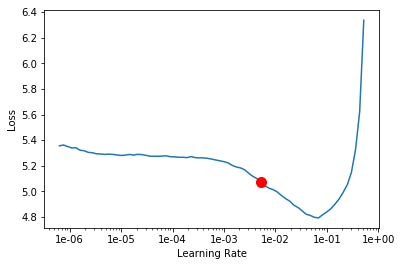

In [58]:
learn.recorder.plot(suggestion=True)

In [59]:
lr = 7e-3
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.726341,2.076566,0.465109,0.756040,03:39
1,2.255011,1.719466,0.544119,0.818297,02:23
2,2.021430,1.491433,0.602574,0.856119,02:22
3,1.808683,1.327129,0.645030,0.878891,02:22
4,1.651319,1.250048,0.664079,0.889030,02:24
5,1.555053,1.230376,0.670139,0.891129,02:24


In [60]:
learn.save('res50-stage-1-128-seed47')

In [61]:
learn.load('res50-stage-1-128-seed47')

Learner(data=ImageDataBunch;

Train: LabelList (37875 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [62]:
learn.unfreeze()

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.74E-06


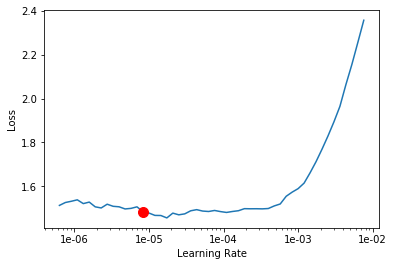

In [66]:
learn.recorder.plot(skip_end=25,suggestion=True)

In [67]:
learn.fit_one_cycle(10,slice(2e-6,lr/5))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.472216,1.196096,0.677505,0.895129,02:23
1,1.460441,1.159871,0.685109,0.901188,02:25
2,1.369312,1.110631,0.697743,0.906970,02:24
3,1.225595,1.054974,0.712079,0.913228,02:24
4,1.045607,1.010160,0.725069,0.917624,02:24
5,0.871723,0.990984,0.732673,0.919960,02:24
6,0.727274,0.968012,0.742020,0.923010,02:23
7,0.613206,0.961956,0.747525,0.925663,02:24
8,0.501318,0.961626,0.748515,0.925980,02:24
9,0.491319,0.961751,0.749545,0.926574,02:24


In [68]:
learn.save('res50-stage-2-128-seed47')

In [69]:
data = (ImageList
        .from_csv(path,'part-train-seed47.csv',folder='images')
        .split_from_df(col='is_valid')
        .label_from_df(cols='label')
        .transform(get_transforms(),size=224)
        .databunch(bs=64,num_workers=8)
        .normalize(imagenet_stats)
)

In [70]:
learn.load('res50-stage-2-128-seed47')

Learner(data=ImageDataBunch;

Train: LabelList (37875 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [71]:
learn.data = data

In [72]:
learn.freeze_to(-1)

In [75]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 7.59E-04


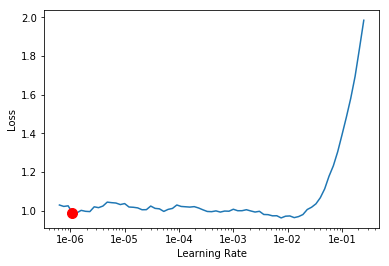

In [76]:
learn.recorder.plot(suggestion=True)

In [77]:
lr = 1e-3

In [78]:
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.840787,0.799053,0.782257,0.942812,03:41
1,0.687589,0.726929,0.799287,0.950139,03:35
2,0.642101,0.714647,0.804158,0.951485,03:35
3,0.582120,0.711058,0.806257,0.952475,03:32
4,0.556183,0.707755,0.807248,0.952396,03:35
5,0.555573,0.711254,0.806812,0.953069,03:34


In [79]:
learn.save('res50-stage-1-224-seed447')

In [80]:
learn.unfreeze()

In [81]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


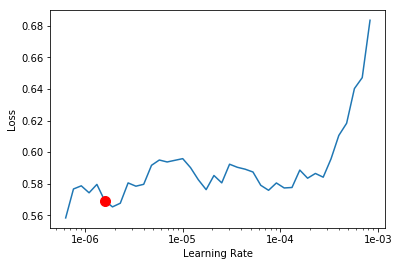

In [84]:
learn.recorder.plot(suggestion=True,skip_end=10)

In [85]:
learn.fit_one_cycle(10,slice(1e-7,lr/5))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.532126,0.707629,0.808634,0.952515,04:17
1,0.562477,0.705956,0.808634,0.952436,04:15
2,0.520073,0.702719,0.810772,0.952475,04:15
3,0.527382,0.700394,0.810059,0.953505,04:16
4,0.490619,0.701167,0.812634,0.954020,04:16
5,0.487013,0.700472,0.812911,0.953743,04:20
6,0.432117,0.699307,0.812950,0.953703,04:16
7,0.412281,0.698959,0.814772,0.953267,04:16
8,0.406000,0.699527,0.814495,0.953703,04:15
9,0.403511,0.698820,0.814614,0.953545,04:15


Using half the training data with 224 size doesn't meet my expectation, I was hoping half of the training set should be able to push to 85% accuracy. 

Changing size here will fall to the technical of data argumentation, which introduce more data should fit the model better.

TODO: Train 224 and 512 on full dataset

In [86]:
learn.save('res50-stage-2-224-seed47')

In [4]:
data = (ImageList
        .from_csv(path,'part-train-seed47.csv',folder='images')
        .split_from_df(col='is_valid')
        .label_from_df(cols='label')
        .transform(get_transforms(),size=512)
        .databunch(bs=16,num_workers=8)
        .normalize(imagenet_stats)
)

In [5]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy,top_k_accuracy])

In [6]:
learn.load('res50-stage-2-224-seed47')

Learner(data=ImageDataBunch;

Train: LabelList (37875 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /home/jupyter/.fastai/data/food-101/food-101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [7]:
learn.data = data

In [8]:
learn.freeze_to(-1)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.31E-03


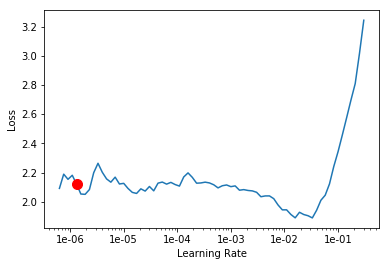

In [10]:
learn.recorder.plot(suggestion=True)

In [11]:
lr = 3e-3

The model won't meet the target (85% accuracy). And 512 size with batch 64 starts to run out memory, with bs 16, size 512, half the training set seems pointless. 

TODO: Train final model on full dataset, also, leave test-set as test-set, not validation set.

In [12]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.232857,0.812079,0.774693,0.943327,14:53
1,1.180274,0.754482,0.791683,0.949149,14:50


KeyboardInterrupt: 

# Fin

Please see the final model